In [1]:
# Необходимые для запуска библиотеки.
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Копия датасета, чтобы не считывать каждый раз файл для перезапуска.
df_copy = pd.read_excel('preprocessed_dataset.xlsx')

In [3]:
df = df_copy
df.head(3)

,full_name,age,height,citizenship,player_agent,current_club,joined,outfitter,social_media,link,...,club_trophies_total_score,club_trophies_average_score,club_trophies_max_score,club_trophies_min_score,club_trophies_amount,Defender_Group,Midfielder_Group,Striker_Group,Winger_Group,followers
0,Joško Gvardiol,22.0,1.85,Croatia,1,Manchester City,7,0,"('Instagram', 'http://www.instagram.com/josko_...",https://www.transfermarkt.com/josko-gvardiol/p...,...,303,37.875,81,8,9,2,0,0,0,1199636
1,Nathan Benjamin Aké,29.0,1.80,Netherlands Cote d'Ivoire,1,Manchester City,43,1,http://www.instagram.com/nathanake/,https://www.transfermarkt.com/nathan-ake/profi...,...,303,37.875,81,8,9,2,0,0,0,2227475
2,Sergio Gómez Martín,23.0,1.71,Spain,1,Manchester City,18,0,http://www.instagram.com/sergiogm_10/,https://www.transfermarkt.com/sergio-gomez/pro...,...,303,37.875,81,8,9,1,0,0,1,475430


In [4]:
# Записываем в y целевую переменную, в X - признаки, не отбрасывая целевую переменную.
y = df.current_price
X = df.select_dtypes(include='number')

In [5]:
# Выведем основные статистики цен футболистов. Основными показателями далее будут
# среднее, минимальное и максимальное значение.
y.describe()

count    1.614000e+04
mean     2.307404e+06
std      7.959596e+06
min      1.000000e+04
25%      1.250000e+05
50%      3.000000e+05
75%      9.500000e+05
max      1.800000e+08
Name: current_price, dtype: float64

In [6]:
# Разбиваем выборку на тренировочную и тестовую.
X_train, X_test, y_train, y_test = train_test_split(X, y,
                      test_size = 0.3, random_state = 123)

In [7]:
# Выберем наиболее скоррелированные с целевой переменной признаки, в том числе и саму цену игрока.
correlations = df.corr().loc['current_price']
most_cor = correlations[abs(correlations.sort_values(ascending=False)) > 0.25].sort_values(ascending=False)
most_cor

current_price                  1.000000
club_price                     0.717240
club_trophies_total_score      0.609049
club_trophies_average_score    0.588237
club_trophies_max_score        0.560580
trophies_total_score           0.557781
followers                      0.435210
club_trophies_amount           0.404782
trophies_amount                0.366064
appearances                    0.321600
national                       0.313771
minutes_played                 0.307366
assists                        0.306196
outfitter                      0.303794
national_assists               0.301737
national_status                0.292823
national_goals                 0.278744
goals                          0.277740
national_matches               0.277164
avg_injuries_per_season        0.270376
club_statistics_goals          0.262088
individual                     0.255321
Name: current_price, dtype: float64

In [8]:
# Оставляем только важные признаки.
X_train = X_train[most_cor.keys()]
X_test = X_test[most_cor.keys()]

In [9]:
# Отмасштабируем признаки.
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=most_cor.keys())
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=most_cor.keys())

In [10]:
# Умножим каждый столбец на его вес, равный значению корреляции с целевой переменной.
# У целевой переменной наибольший вес (1.0), что сделает её вклад больше, чем у
# остальных переменных в сумму расстояний до k ближайших соседей.
for column in most_cor.keys():
  X_train_scaled[column] = X_train_scaled[column] * most_cor[column]
  X_test_scaled[column] = X_test_scaled[column] * most_cor[column]

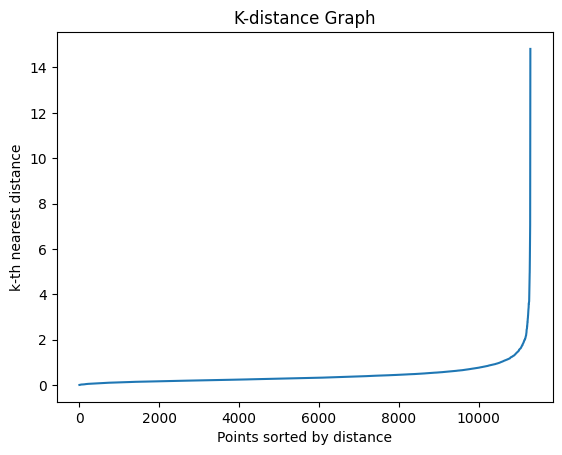

In [11]:
# Выведем график суммы расстояний для k ближайших соседей,
# отсортированных по возрастанаию и отсечём уровень, на
# котором будут отсекаться аномалии (выбросы).
k = 50
neigh = NearestNeighbors(n_neighbors=k)
neigh.fit(X_train_scaled)
distances, indices = neigh.kneighbors(X_train_scaled)

distances = np.sort(distances[:, 1], axis=0)

plt.plot(distances)
plt.title("K-distance Graph")
plt.xlabel("Points sorted by distance")
plt.ylabel("k-th nearest distance")
plt.show()

Возьмём уровень $h=1$, затем посмотрим на получаемые данные.

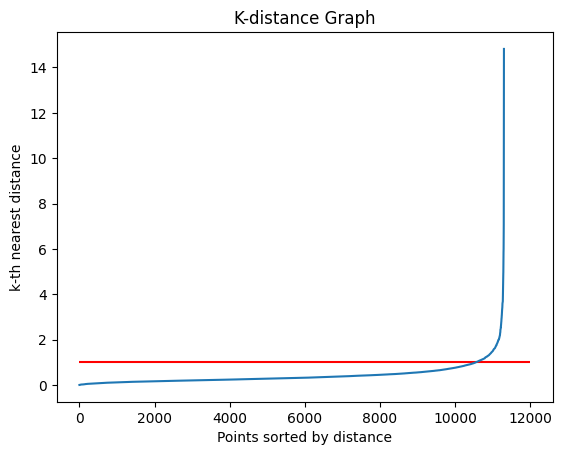

In [12]:
k = 50
neigh = NearestNeighbors(n_neighbors=k)
neigh.fit(X_train_scaled)
distances, indices = neigh.kneighbors(X_train_scaled)

distances = np.sort(distances[:, 1], axis=0)

plt.hlines(y=1, xmin=0, xmax=12000, color='red')
plt.plot(distances)
plt.title("K-distance Graph")
plt.xlabel("Points sorted by distance")
plt.ylabel("k-th nearest distance")
plt.show()

In [13]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=1, min_samples=50)
dbscan.fit(X_train_scaled)

outlier_indices = np.where(dbscan.labels_ == -1)[0] # Индексы выбросов

print(f"Indices of outlier points: {outlier_indices};\tShape: {outlier_indices.shape[0]};\tInitial Shape: {X_train.shape[0]}")
# Всего было помечено как выброс 1355 объекта из 11298.

Indices of outlier points: [    0     2     5 ... 11277 11283 11294];	Shape: 1355;	Initial Shape: 11298


In [14]:
# Посмотрим распределение цены в получившихся аномалиях
outliers = y_train.iloc[outlier_indices]
outliers.describe()
# Заметим, что самый дорогой и самый дешёвый игроки попали в предполагаемые
# моделью выбросы, а также среднее среди предполагаемых выбросов (1.5млрд) сильно
# выше среднего среди исходного среднего (можно посмотреть выше при выводе
# статистик цен игроков до разделения выборки на train и test), что может быть
# признаком того, что данная модель корректно определяет выбросы с точки зрения цены.

count    1.355000e+03
mean     1.461947e+07
std      1.886199e+07
min      1.000000e+04
25%      2.500000e+06
50%      8.000000e+06
75%      1.800000e+07
max      1.800000e+08
Name: current_price, dtype: float64

In [15]:
# Посмотрим распределение цены при удалении аномалий
without_outliers = y_train.drop(y_train.iloc[outlier_indices].index)
without_outliers.describe()
# Заметим, что средняя цена упала.

count    9.943000e+03
mean     6.500161e+05
std      1.197659e+06
min      1.000000e+04
25%      1.000000e+05
50%      2.500000e+05
75%      6.000000e+05
max      1.400000e+07
Name: current_price, dtype: float64

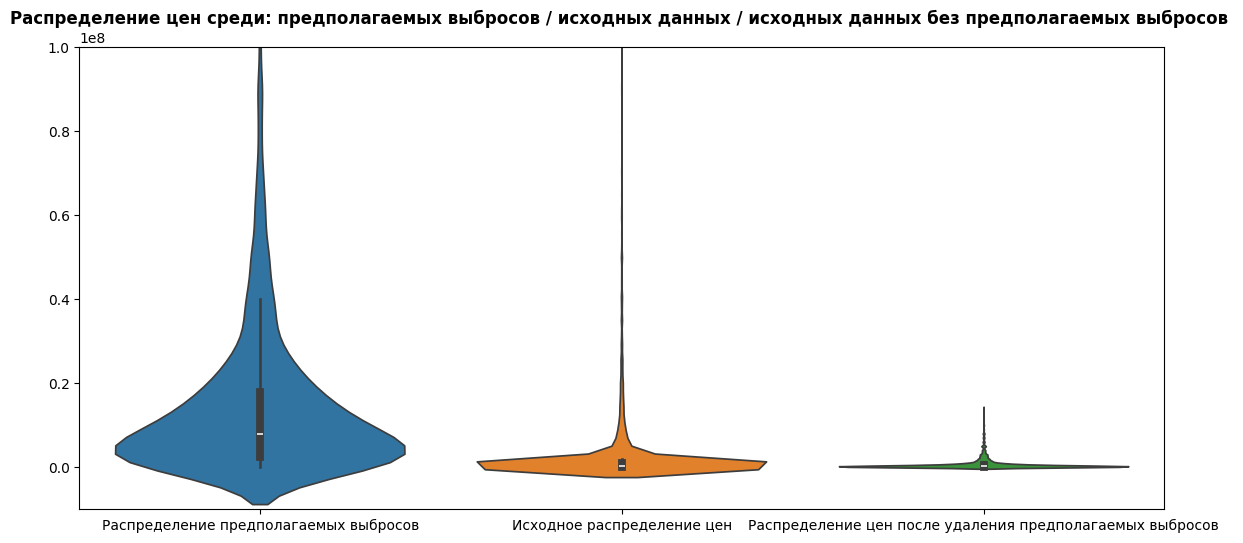

In [16]:
# Построение графиков распределения цен.
fig, ax = plt.subplots(figsize=(14, 6))
violins = pd.DataFrame({'Распределение предполагаемых выбросов': outliers,
                        'Исходное распределение цен': y_train,
                        'Распределение цен после удаления предполагаемых выбросов': without_outliers})
sns.violinplot(data=violins)

ax.set_ylim(-1e7, 1e8)
plt.title('Распределение цен среди: предполагаемых выбросов / исходных данных / исходных данных без предполагаемых выбросов ', weight='bold')
plt.show()

Как можно заметить, выбросы действительно имеют очень сильный разброс значений судя по графику и после их удаления (удаляется лишь 1355 строк из 11298) график распределения цен очень сильно сжимается, что должно существенно улучшить качество получаемых моделей, так как теперь распределение цен исправлено. Для проверки модели построим такой же график на тестовой выборке:

In [17]:
dbscan.fit(X_test_scaled)
outlier_indices = np.where(dbscan.labels_ == -1)[0] # Индексы выбросов
print(f"Indices of outlier points: {outlier_indices};\tShape: {outlier_indices.shape[0]};\tInitial Shape: {X_test.shape[0]}")
# Всего было помечено как выброс 712 объекта из 4842.

Indices of outlier points: [   7   11   17   26   32   37   44   46   56   61   71   74   87   89
   92   99  124  140  141  142  144  155  158  160  165  170  173  189
  195  204  219  220  235  245  251  254  267  269  271  272  287  290
  308  312  333  339  343  370  377  383  386  389  392  395  400  403
  408  413  417  426  427  431  432  438  445  450  470  474  488  490
  493  495  505  511  512  523  530  532  543  554  559  575  578  586
  598  601  602  603  612  626  632  637  645  658  661  671  674  676
  695  703  709  710  712  721  742  744  747  752  754  756  766  776
  783  784  785  786  790  793  794  804  813  825  826  833  836  839
  845  846  847  848  852  865  866  877  878  879  882  903  912  917
  923  929  937  941  942  947  955  959  961  974  984  988 1004 1005
 1029 1039 1042 1044 1051 1065 1066 1073 1074 1080 1092 1105 1112 1115
 1117 1119 1121 1123 1131 1141 1146 1149 1157 1158 1164 1176 1183 1185
 1188 1198 1207 1211 1215 1216 1222 1229 1231 1239

In [18]:
outliers = y_test.iloc[outlier_indices]
outliers.describe()

count    7.120000e+02
mean     1.174397e+07
std      1.733572e+07
min      1.000000e+04
25%      1.500000e+06
50%      6.000000e+06
75%      1.500000e+07
max      1.800000e+08
Name: current_price, dtype: float64

In [19]:
without_outliers = y_test.drop(y_test.iloc[outlier_indices].index)
without_outliers.describe()

count    4.130000e+03
mean     6.313063e+05
std      1.113184e+06
min      1.000000e+04
25%      1.000000e+05
50%      2.500000e+05
75%      6.000000e+05
max      1.000000e+07
Name: current_price, dtype: float64

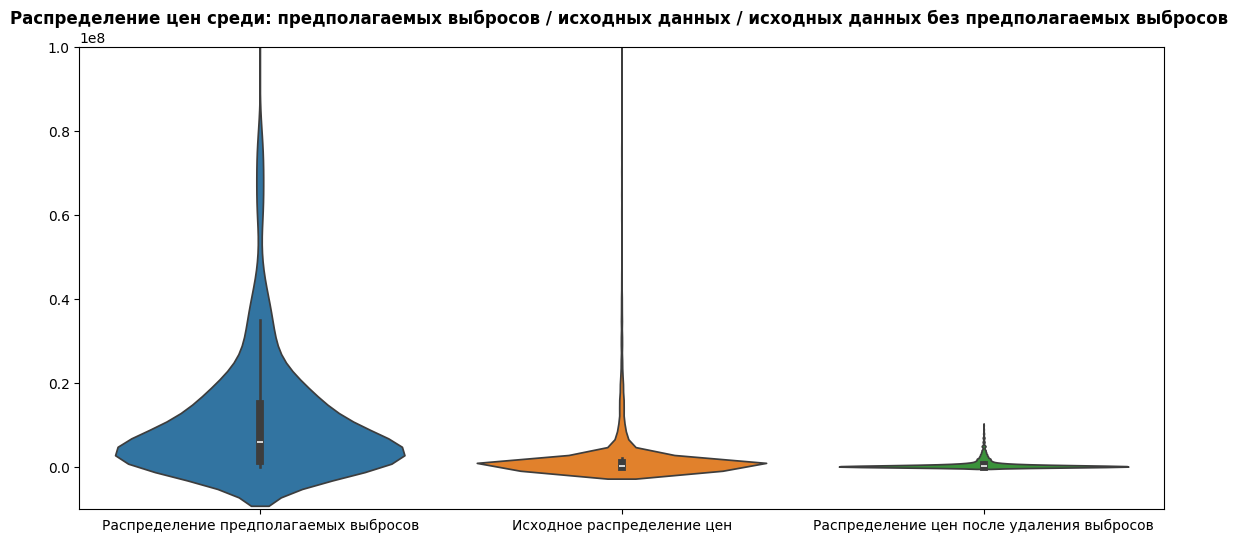

In [20]:
# Построение графиков распределения цен.
fig, ax = plt.subplots(figsize=(14, 6))
violins = pd.DataFrame({'Распределение предполагаемых выбросов': outliers,
                        'Исходное распределение цен': y_test,
                        'Распределение цен после удаления выбросов': without_outliers})
sns.violinplot(data=violins)

ax.set_ylim(-1e7, 1e8)
plt.title('Распределение цен среди: предполагаемых выбросов / исходных данных / исходных данных без предполагаемых выбросов ', weight='bold')
plt.show()

Как можно заметить, полученная модель DBSCAN также хорошо справилась с исправлением данных в тестовой выборке, поэтому сохраним эту модель.

In [21]:
# Сохранение модели в файл формата .pkl
import pickle
with open('best_dbscan_model.pkl', 'wb') as file:
    pickle.dump(dbscan, file)

In [33]:
# Сохранение полученных обучающей и тестовой выборок.
dbscan.fit(X_train_scaled)
train_data = X_train.iloc[np.where(dbscan.labels_ != -1)[0]]
y_train_without_outliers = y_train.iloc[np.where(dbscan.labels_ != -1)[0]]
train_data['current_price'] = y_train_without_outliers
train_data.to_excel("train.xlsx")

dbscan.fit(X_test_scaled)
test_data = X_test.iloc[np.where(dbscan.labels_ != -1)[0]]
y_test_without_outliers = y_test.iloc[np.where(dbscan.labels_ != -1)[0]]
test_data['current_price'] = y_test_without_outliers
test_data.to_excel("test.xlsx")